In [ ]:
!pip install evaluate

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler
from tqdm.auto import tqdm
import evaluate
import uuid

from classification import ReviewDataSet, load_and_prepare_data, train_model


In [11]:
# load data
print("loading data...\n")
path = "drive/MyDrive/yelp_reviews"
df = load_and_prepare_data(path+"/yelp_academic_dataset_review.json", sample_size=75000, COLAB=True)

loading data...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# create dataset
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', use_fast=False)
review_dataset = ReviewDataSet(tokenizer, df)

In [13]:
# train and val split
train_size = int(0.8 * len(review_dataset))
val_size = len(review_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(review_dataset, [train_size, val_size], generator)
print(f'train and validation dataset sizes: {len(train_dataset), len(val_dataset)}\n')

train and validation dataset sizes: (23876, 5969)



In [14]:
# dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [15]:
# initialize model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=5)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_params = sum([p.numel() for p in model.parameters()])
print(f"model params: {num_params}\n")

epochs = 5
train_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name='linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=train_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model params: 108314117



In [ ]:
# set device and send model to device
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
model.to(device)

In [17]:
device

device(type='cuda')

beginning model training...



  0%|          | 0/7465 [00:00<?, ?it/s]

model id :: 302656d9-aa1a-4028-94d4-3fda972caf28
evaluating model...

Accuracy: 0.5848550846037862
saving model at epoch: 1, step: 746
current best accuracy: 0.5848550846037862

evaluating model...

Accuracy: 0.6285810018428547
saving model at epoch: 1, step: 1492
current best accuracy: 0.6285810018428547

evaluating model...

Accuracy: 0.6326017758418495
saving model at epoch: 2, step: 746
current best accuracy: 0.6326017758418495

evaluating model...

Accuracy: 0.6460043558384989
saving model at epoch: 2, step: 1492
current best accuracy: 0.6460043558384989

evaluating model...

Accuracy: 0.637460211090635
skipping model save...
current best accuracy: 0.6460043558384989

evaluating model...

Accuracy: 0.6424861785893785
skipping model save...
current best accuracy: 0.6460043558384989

evaluating model...

Accuracy: 0.6393030658401743
skipping model save...
current best accuracy: 0.6460043558384989

evaluating model...

Accuracy: 0.6372926788406769
skipping model save...
current best 

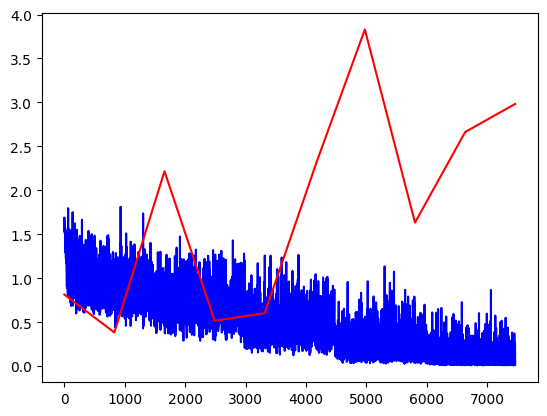

In [18]:
# train model
print("beginning model training...\n")
train_model(model, epochs, train_dataloader, val_dataloader, train_steps, optimizer, lr_scheduler, path)
print("complete")

In [ ]:
# load pretrained model
# path = "drive/MyDrive/yelp_reviews/bert_model"
path = "drive/MyDrive/yelp_reviews/outputs/bert/302656d9-aa1a-4028-94d4-3fda972caf28/epoch_2/step_1492/"

model = AutoModelForSequenceClassification.from_pretrained(path)
model.to(device)